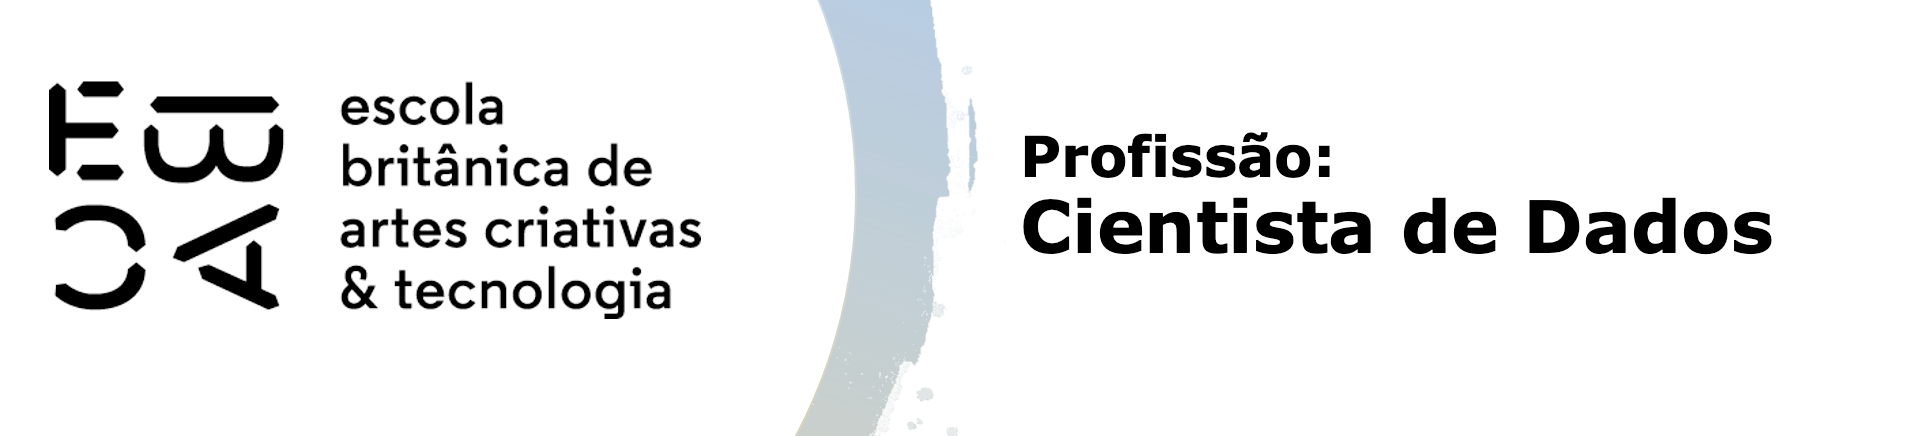

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as ss 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from ydata_profiling import ProfileReport
from scipy.stats import t
from sklearn import metrics
from scipy.stats import ks_2samp

In [2]:
df = pd.read_feather('./credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

In [3]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [4]:
df2 = df.copy()

In [5]:
df2['tempo_emprego'] =df2['tempo_emprego'].fillna(df2['tempo_emprego'].mean())

In [6]:
df2.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

In [7]:
df2.tempo_emprego.describe()

count    750000.000000
mean          7.748574
std           6.100107
min           0.117808
25%           3.635616
50%           7.473973
75%           9.090411
max          42.906849
Name: tempo_emprego, dtype: float64

In [8]:
df2 = df2.reset_index()

In [9]:
df2['data_ref'] = pd.to_datetime(df2['data_ref'])

In [10]:
df2['mau'] = df2.mau.astype('int64')

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [11]:
df2 = df2.drop(['level_0', 'index'], axis=1)
df2 = df2.reset_index()

In [12]:
# Determinar a data inicial dos últimos três meses
tempo = df2['data_ref'].max() - pd.DateOffset(months=3)

In [13]:
#Separa o DF dos ultimos 3 meses para teste
oot_df = df2[df['data_ref'] >= tempo]

In [14]:
train_df = df2.drop(oot_df.index)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550000 entries, 0 to 549999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   index                  550000 non-null  int64         
 1   data_ref               550000 non-null  datetime64[ns]
 2   sexo                   550000 non-null  object        
 3   posse_de_veiculo       550000 non-null  object        
 4   posse_de_imovel        550000 non-null  object        
 5   qtd_filhos             550000 non-null  int64         
 6   tipo_renda             550000 non-null  object        
 7   educacao               550000 non-null  object        
 8   estado_civil           550000 non-null  object        
 9   tipo_residencia        550000 non-null  object        
 10  idade                  550000 non-null  int64         
 11  tempo_emprego          550000 non-null  float64       
 12  qt_pessoas_residencia  550000 non-null  floa

In [16]:
oot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 550000 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   index                  200000 non-null  int64         
 1   data_ref               200000 non-null  datetime64[ns]
 2   sexo                   200000 non-null  object        
 3   posse_de_veiculo       200000 non-null  object        
 4   posse_de_imovel        200000 non-null  object        
 5   qtd_filhos             200000 non-null  int64         
 6   tipo_renda             200000 non-null  object        
 7   educacao               200000 non-null  object        
 8   estado_civil           200000 non-null  object        
 9   tipo_residencia        200000 non-null  object        
 10  idade                  200000 non-null  int64         
 11  tempo_emprego          200000 non-null  float64       
 12  qt_pessoas_residencia  200000 non-null 

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [17]:
# Número de linhas no DataFrame
num_linhas = train_df.shape[0]
print(f"Número de linhas: {num_linhas}")

Número de linhas: 550000


In [18]:
# 2. Número de linhas para cada mês em data_ref
linhas_por_mes = train_df['data_ref'].dt.to_period('M').value_counts().sort_index()
print("\nNúmero de linhas para cada mês em data_ref:")
print(linhas_por_mes)


Número de linhas para cada mês em data_ref:
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
Freq: M, Name: data_ref, dtype: int64



Descritiva univariada das variáveis qualitativas:


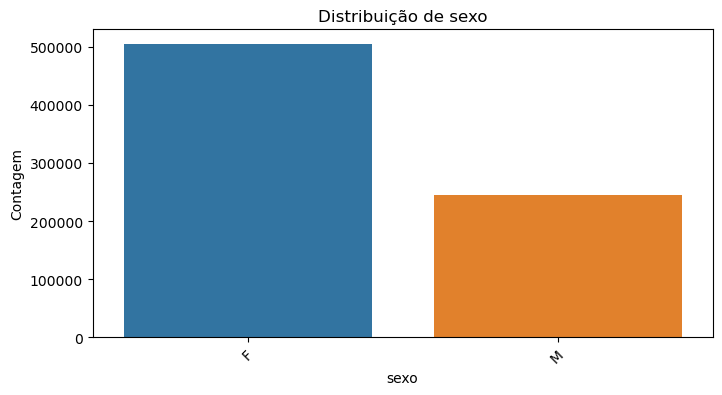

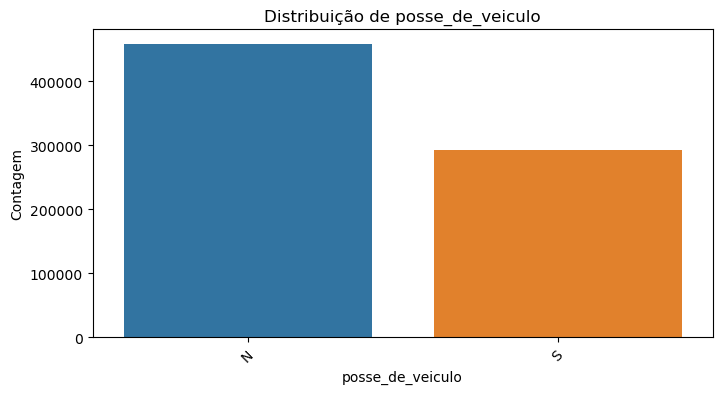

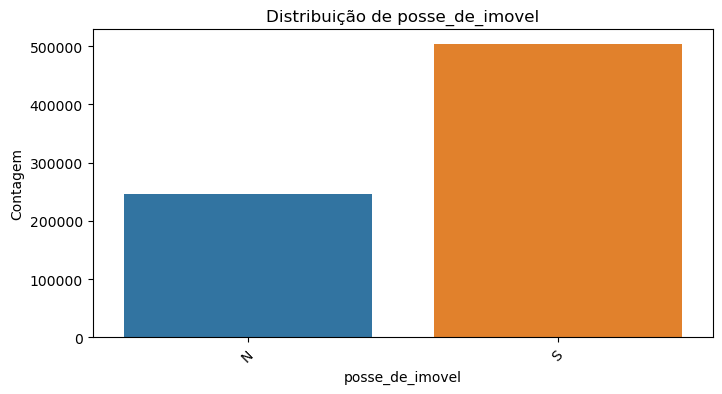

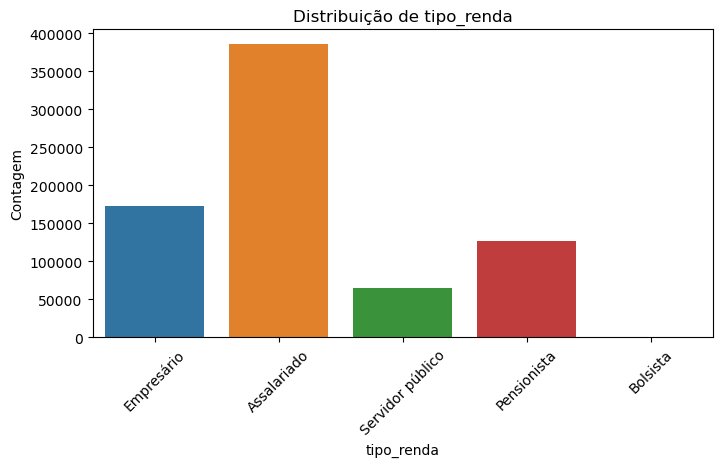

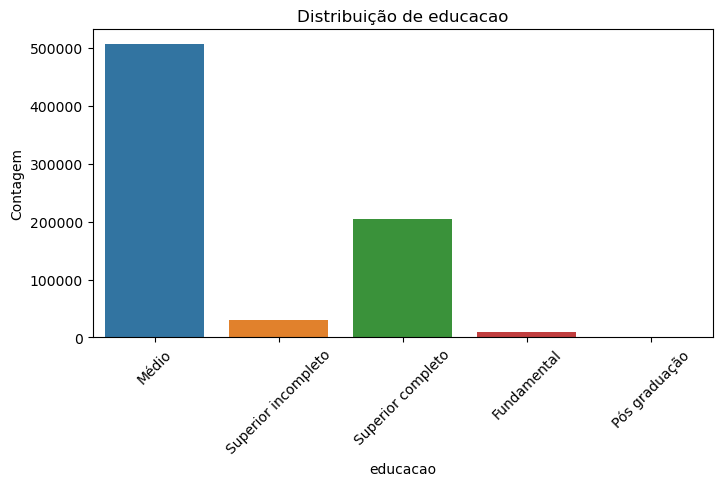

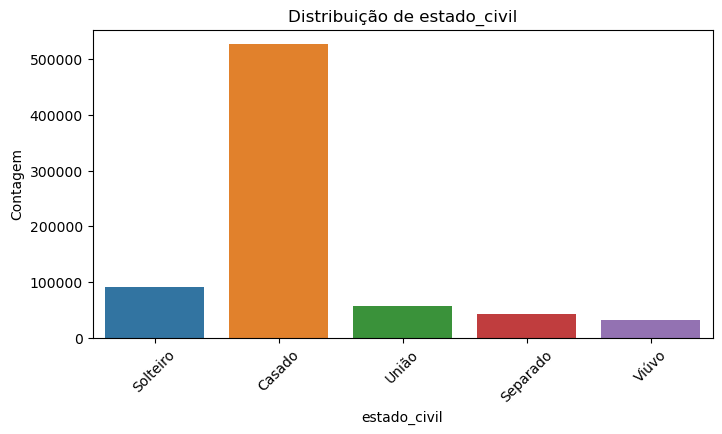

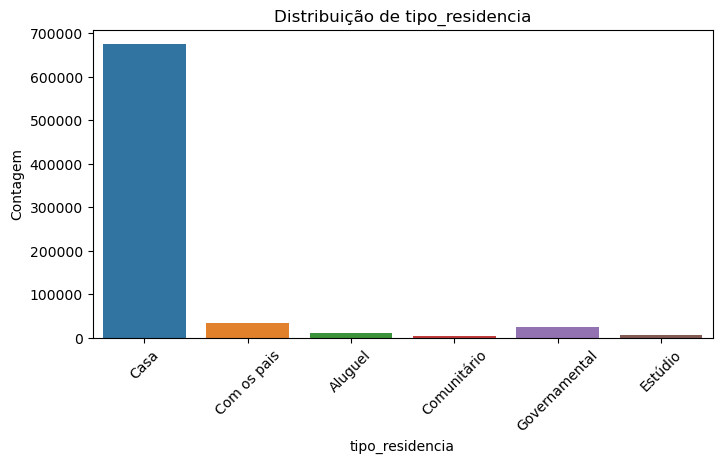

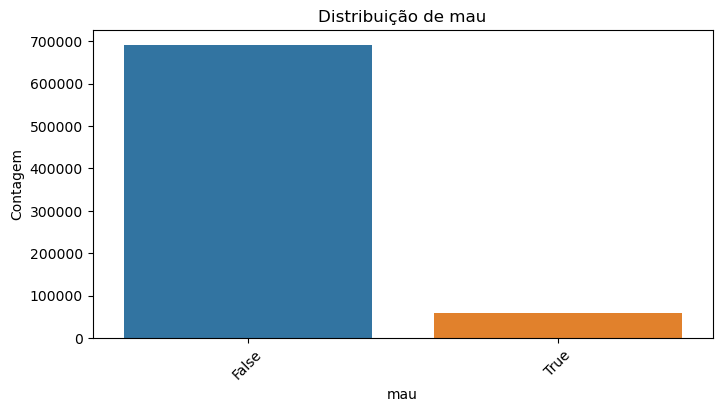

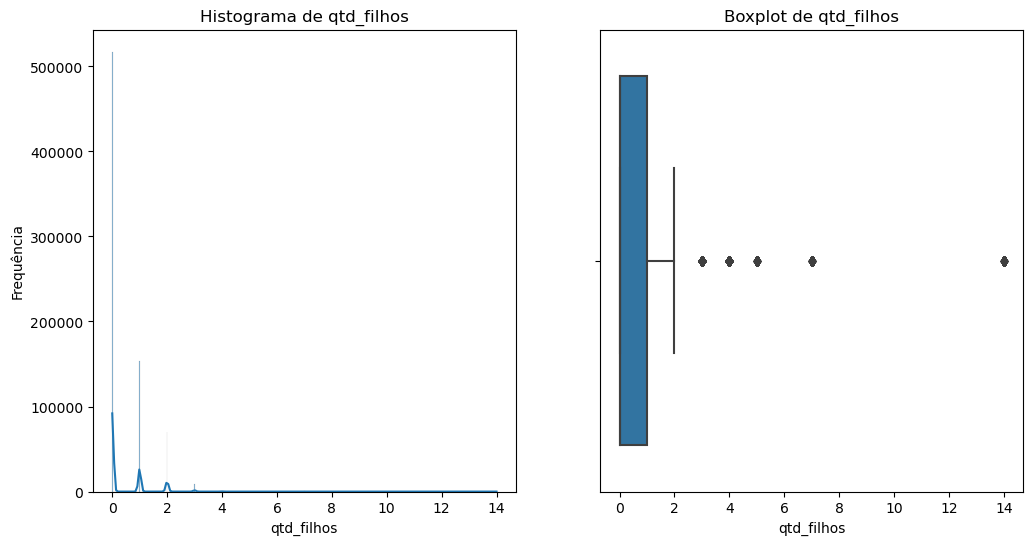

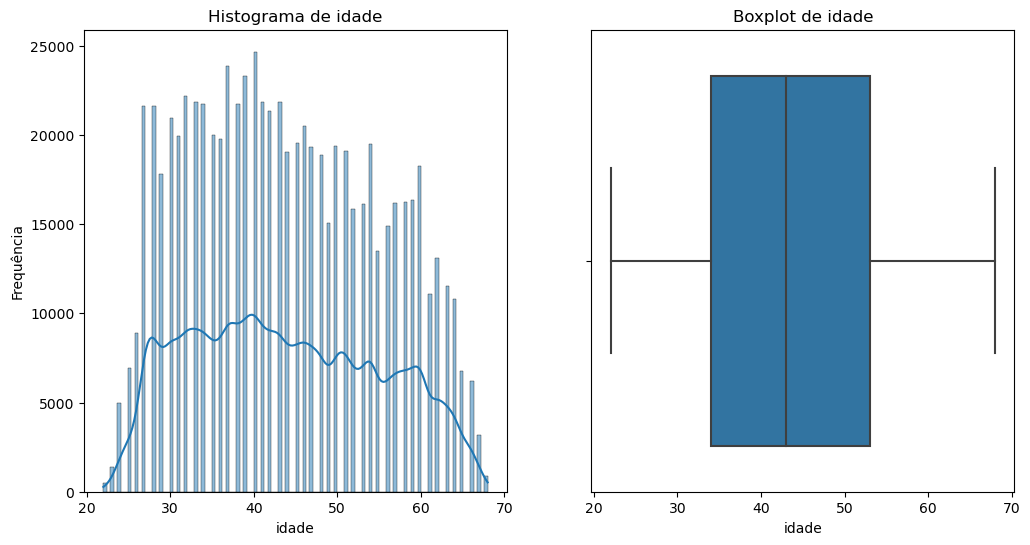

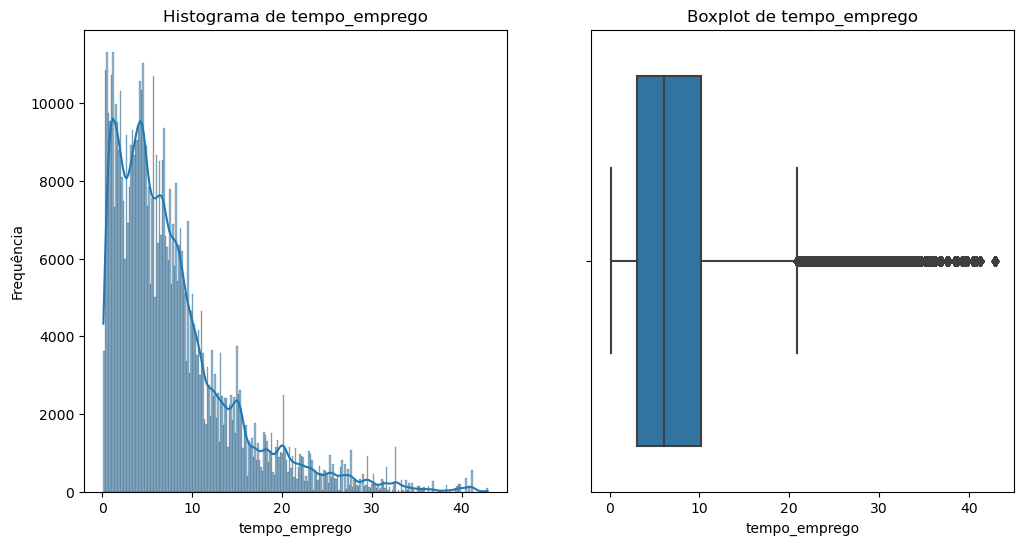

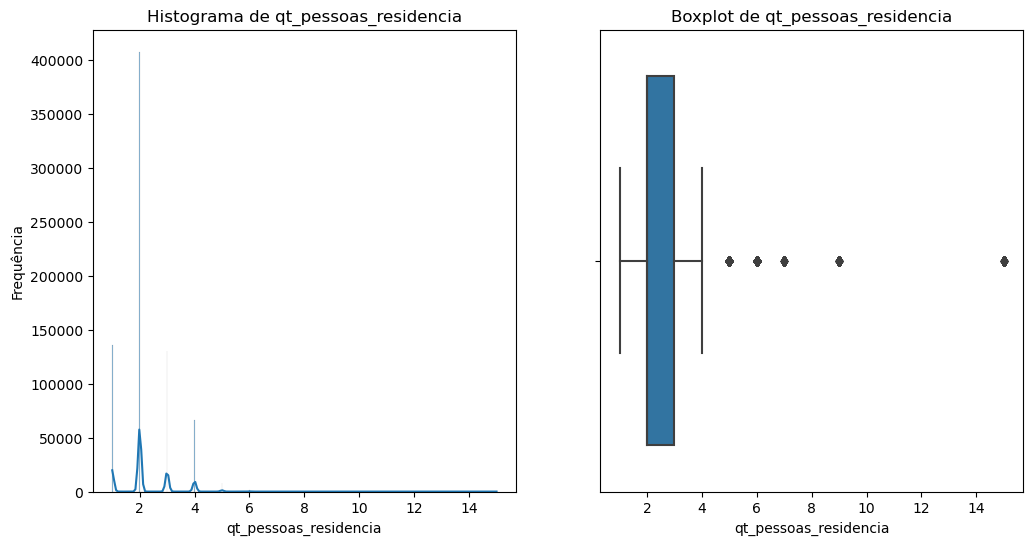

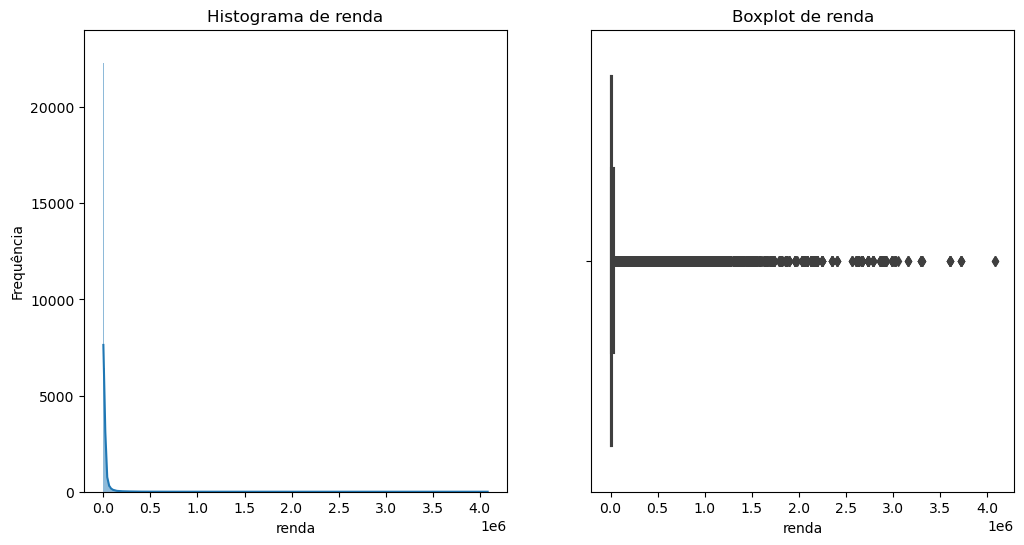

In [19]:
#Descritiva básica univariada para cada variável

# Variáveis qualitativas
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']

print("\nDescritiva univariada das variáveis qualitativas:")
for col in variaveis_qualitativas:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)
    plt.show()

# Variáveis quantitativas
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

for col in variaveis_quantitativas:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    
    plt.show()


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [20]:
prof = ProfileReport(train_df, explorative=True)
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
prof.to_file('./Logistic-profile.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [22]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [23]:
metadados = pd.DataFrame(train_df.dtypes, columns=['dtype'])
metadados['nmissing'] = train_df.isna().sum()
metadados['valores_unicos'] = train_df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados.drop(['df_index','data_ref'], inplace=True)
metadados

dtype  nmissing  valores_unicos       papel
sexo                    object       0.0             2.0  covariavel
posse_de_veiculo        object       0.0             2.0  covariavel
posse_de_imovel         object       0.0             2.0  covariavel
qtd_filhos               int64       0.0             8.0  covariavel
tipo_renda              object       0.0             5.0  covariavel
educacao                object       0.0             5.0  covariavel
estado_civil            object       0.0             5.0  covariavel
tipo_residencia         object       0.0             6.0  covariavel
idade                    int64       0.0            47.0  covariavel
tempo_emprego          float64       0.0          3005.0  covariavel
qt_pessoas_residencia  float64       0.0             9.0  covariavel
renda                  float64       0.0        111722.0  covariavel
mau                      int64       0.0             2.0    resposta
bom                        NaN       NaN             NaN    resposta

In [24]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

    
metadados

dtype  nmissing  valores_unicos       papel        IV
sexo                    object       0.0             2.0  covariavel  0.002185
posse_de_veiculo        object       0.0             2.0  covariavel  0.000108
posse_de_imovel         object       0.0             2.0  covariavel  0.009693
qtd_filhos               int64       0.0             8.0  covariavel  0.000030
tipo_renda              object       0.0             5.0  covariavel  0.009360
educacao                object       0.0             5.0  covariavel  0.003547
estado_civil            object       0.0             5.0  covariavel  0.001126
tipo_residencia         object       0.0             6.0  covariavel  0.003045
idade                    int64       0.0            47.0  covariavel  0.017968
tempo_emprego          float64       0.0          3005.0  covariavel  0.351920
qt_pessoas_residencia  float64       0.0             9.0  covariavel  0.001346
renda                  float64       0.0        111722.0  covariavel  1.068628
mau                      int64       0.0             2.0    resposta       NaN
bom                        NaN       NaN             NaN    resposta       NaN

In [25]:
#junção de dados do DF para melhorar acurácia do modelo
df2.tipo_renda.replace({'Bolsista':'Assalariado/Bolsista/Pensionista', 'Pensionista': 'Assalariado/Bolsista/Pensionista', 'Assalariado': 'Assalariado/Bolsista/Pensionista'}, inplace=True)
df2.educacao.replace({'Superior completo':'Superior/Pos', 'Pós graduação': 'Superior/Pos'}, inplace=True)
df2.educacao.replace({'Superior incompleto':'sem_superior', 'Médio': 'sem_superior', 'Fundamental': 'sem_superior'}, inplace=True)
df2.estado_civil.replace({'Solteiro':'nao_casado', 'Separado': 'nao_casado', 'Viúvo': 'nao_casado', 'União': 'nao_casado'}, inplace=True)
df2.tipo_residencia.replace({'Com os pais':'nao_propria', 'Aluguel': 'nao_propria', 'Comunitário': 'nao_propria', 'Governamental': 'nao_propria'}, inplace=True)
df2.tipo_residencia.replace({'Casa':'propria', 'Estúdio': 'propria'}, inplace=True)

In [26]:
#Separa o DF dos ultimos 3 meses para teste
oot_df = df2[df['data_ref'] >= tempo]

In [27]:
train_df = df2.drop(oot_df.index)

**Vamos agrupar alguma categoria com baixo volume de dados para averiguar se o IV aumenta e fica significante para ser inserido no modelo**

In [29]:
metadados = pd.DataFrame(train_df.dtypes, columns=['dtype'])
metadados['nmissing'] = train_df.isna().sum()
metadados['valores_unicos'] = train_df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados.drop(['index','data_ref'], inplace=True)
metadados

dtype  nmissing  valores_unicos       papel
sexo                    object       0.0             2.0  covariavel
posse_de_veiculo        object       0.0             2.0  covariavel
posse_de_imovel         object       0.0             2.0  covariavel
qtd_filhos               int64       0.0             8.0  covariavel
tipo_renda              object       0.0             3.0  covariavel
educacao                object       0.0             2.0  covariavel
estado_civil            object       0.0             2.0  covariavel
tipo_residencia         object       0.0             2.0  covariavel
idade                    int64       0.0            47.0  covariavel
tempo_emprego          float64       0.0          3005.0  covariavel
qt_pessoas_residencia  float64       0.0             9.0  covariavel
renda                  float64       0.0        111722.0  covariavel
mau                      int64       0.0             2.0    resposta
bom                        NaN       NaN             NaN    resposta

In [30]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

    
metadados

dtype  nmissing  valores_unicos       papel        IV
sexo                    object       0.0             2.0  covariavel  0.002185
posse_de_veiculo        object       0.0             2.0  covariavel  0.000108
posse_de_imovel         object       0.0             2.0  covariavel  0.009693
qtd_filhos               int64       0.0             8.0  covariavel  0.000030
tipo_renda              object       0.0             3.0  covariavel  0.009360
educacao                object       0.0             2.0  covariavel  0.003547
estado_civil            object       0.0             2.0  covariavel  0.001126
tipo_residencia         object       0.0             2.0  covariavel  0.003045
idade                    int64       0.0            47.0  covariavel  0.017968
tempo_emprego          float64       0.0          3005.0  covariavel  0.351920
qt_pessoas_residencia  float64       0.0             9.0  covariavel  0.001346
renda                  float64       0.0        111722.0  covariavel  1.068628
mau                      int64       0.0             2.0    resposta       NaN
bom                        NaN       NaN             NaN    resposta       NaN

In [31]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    plt.subplots_adjust(hspace=0.5)
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

C:\Users\eric_\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\eric_\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\eric_\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


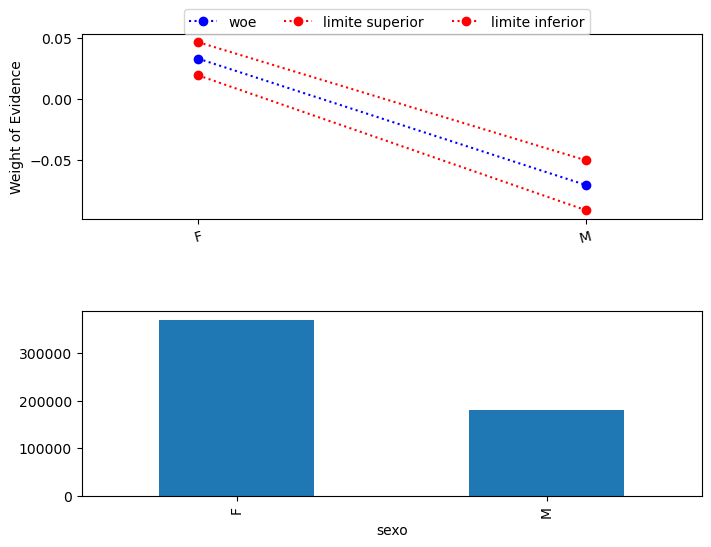

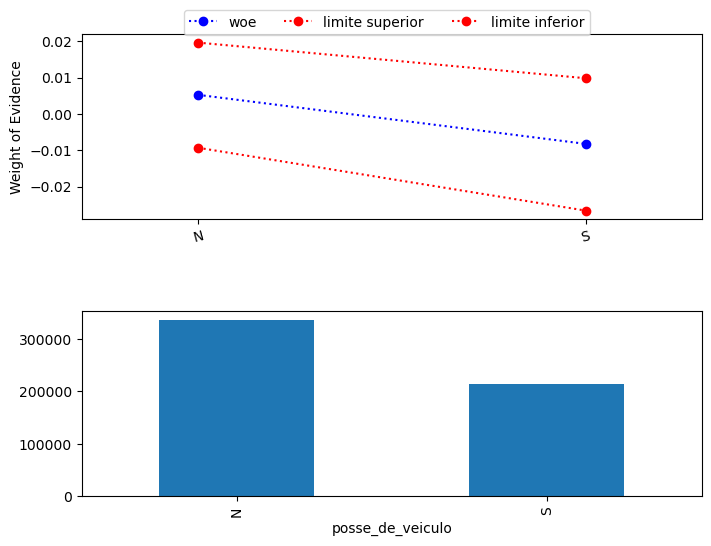

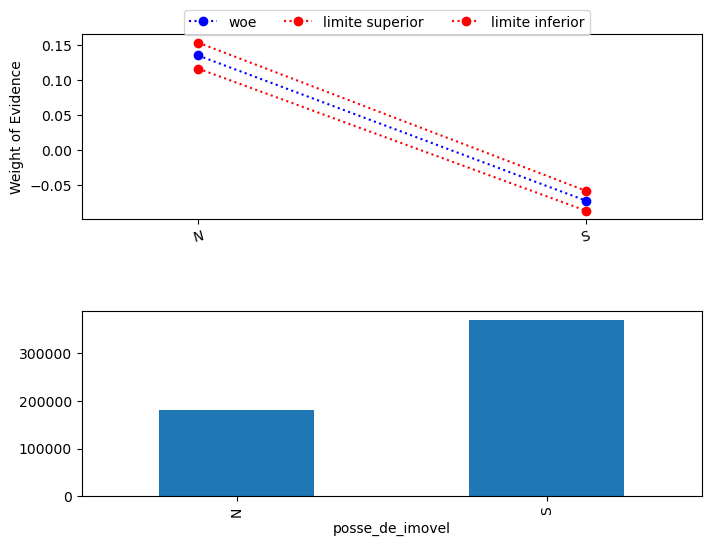

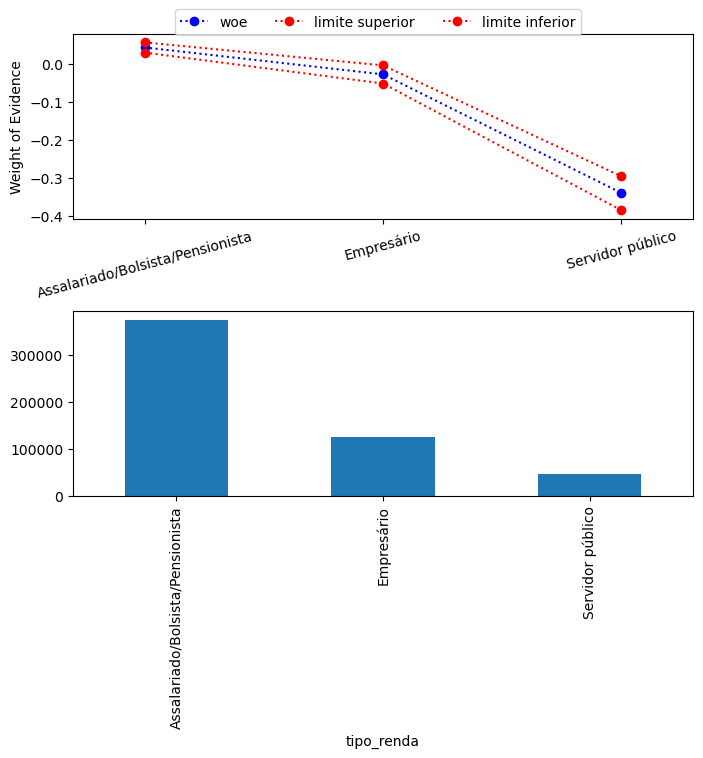

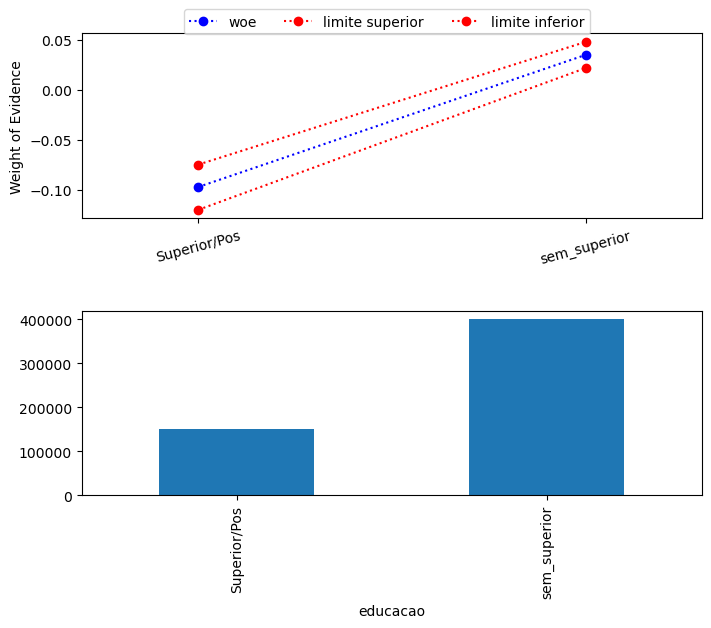

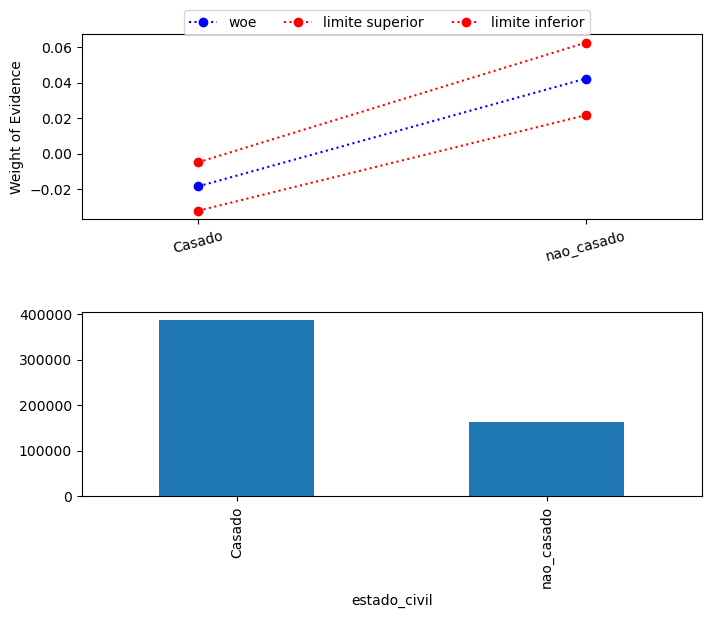

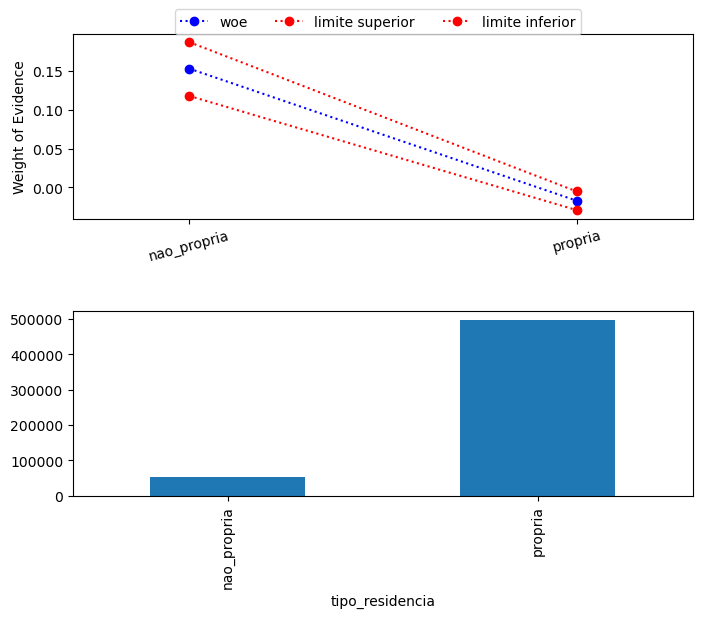

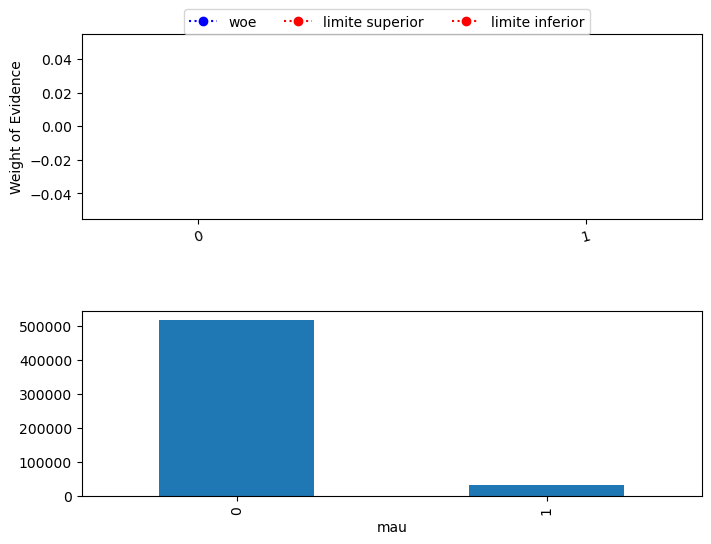

In [32]:
for var in variaveis_qualitativas:
    
    biv_discreta(var, train_df);

In [33]:
# ajuda para definir a equação da regressão
' + '.join(list(df.columns))

'data_ref + index + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau'

In [34]:
formula = '''
    mau ~ sexo + posse_de_veiculo +
    posse_de_imovel + qtd_filhos + tipo_renda + educacao +
    estado_civil + tipo_residencia + idade + tempo_emprego +
    qt_pessoas_residencia + renda
'''

rl = smf.glm(formula, data=train_df, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               550000
Model:                            GLM   Df Residuals:                   549986
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1007e+05
Date:                Thu, 04 Jul 2024   Deviance:                   2.2004e+05
Time:                        15:54:36   Pearson chi2:                 9.65e+15
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04059
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.6573      0.058    -28.402      0.000      -1.772      -1.543
sexo[T.M]                         -0.1116      0.014     -7.979      0.000      -0.139      -0.084
posse_de_veiculo[T.S]              0.0326      0.013      2.465      0.014       0.007       0.058
posse_de_imovel[T.S]              -0.0843      0.013     -6.687      0.000      -0.109      -0.060
tipo_renda[T.Empresário]          -0.0429      0.015     -2.915      0.004      -0.072      -0.014
tipo_renda[T.Servidor público]    -0.0414      0.025     -1.676      0.094      -0.090       0.007
educacao[T.sem_superior]           0.0537      0.014      3.849      0.000       0.026       0.081
estado_civil[T.nao_casado]         0.0509      0.021      2.377      0.017       0.009       0.093
tipo_residencia[T.propria]        -0.0181      0.020     -0.921      0.357      -0.057       0.020
qtd_filhos                        -0.0344      0.025     -1.356      0.175      -0.084       0.015
idade                             -0.0007      0.001     -1.071      0.284      -0.002       0.001
tempo_emprego                     -0.0225      0.002    -11.852      0.000      -0.026      -0.019
qt_pessoas_residencia              0.0428      0.024      1.815      0.069      -0.003       0.089
renda                          -9.769e-05   1.11e-06    -88.388      0.000   -9.99e-05   -9.55e-05
==================================================================================================
"""

O tipo de residencia possui um P-Value fora da margem aceitavel, vamos remover.

In [35]:
formula = '''
    mau ~ sexo + posse_de_veiculo +
    posse_de_imovel + qtd_filhos + tipo_renda + educacao +
    estado_civil + idade + tempo_emprego +
    qt_pessoas_residencia + renda
'''

rl = smf.glm(formula, data=train_df, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               550000
Model:                            GLM   Df Residuals:                   549987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1007e+05
Date:                Thu, 04 Jul 2024   Deviance:                   2.2004e+05
Time:                        15:54:45   Pearson chi2:                 9.65e+15
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04059
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.6680      0.057    -29.173      0.000      -1.780      -1.556
sexo[T.M]                         -0.1114      0.014     -7.967      0.000      -0.139      -0.084
posse_de_veiculo[T.S]              0.0325      0.013      2.458      0.014       0.007       0.058
posse_de_imovel[T.S]              -0.0864      0.012     -6.977      0.000      -0.111      -0.062
tipo_renda[T.Empresário]          -0.0433      0.015     -2.946      0.003      -0.072      -0.015
tipo_renda[T.Servidor público]    -0.0412      0.025     -1.666      0.096      -0.090       0.007
educacao[T.sem_superior]           0.0539      0.014      3.856      0.000       0.026       0.081
estado_civil[T.nao_casado]         0.0508      0.021      2.373      0.018       0.009       0.093
qtd_filhos                        -0.0341      0.025     -1.345      0.179      -0.084       0.016
idade                             -0.0007      0.001     -1.184      0.236      -0.002       0.000
tempo_emprego                     -0.0225      0.002    -11.907      0.000      -0.026      -0.019
qt_pessoas_residencia              0.0423      0.024      1.796      0.073      -0.004       0.089
renda                          -9.769e-05   1.11e-06    -88.385      0.000   -9.99e-05   -9.55e-05
==================================================================================================
"""

Vamos usar o mesmo reciocinio e remover quantidade de filhos e idade do modelo.

In [36]:
formula = '''
    mau ~ sexo + posse_de_veiculo +
    posse_de_imovel +  tipo_renda + educacao +
    estado_civil  + tempo_emprego +
    qt_pessoas_residencia + renda
'''

rl = smf.glm(formula, data=train_df, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               550000
Model:                            GLM   Df Residuals:                   549989
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1008e+05
Date:                Thu, 04 Jul 2024   Deviance:                   2.2005e+05
Time:                        15:54:54   Pearson chi2:                 9.66e+15
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04059
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.6449      0.027    -60.230      0.000      -1.698      -1.591
sexo[T.M]                         -0.1091      0.014     -7.891      0.000      -0.136      -0.082
posse_de_veiculo[T.S]              0.0338      0.013      2.563      0.010       0.008       0.060
posse_de_imovel[T.S]              -0.0889      0.012     -7.263      0.000      -0.113      -0.065
tipo_renda[T.Empresário]          -0.0401      0.015     -2.762      0.006      -0.068      -0.012
tipo_renda[T.Servidor público]    -0.0386      0.025     -1.570      0.116      -0.087       0.010
educacao[T.sem_superior]           0.0526      0.014      3.796      0.000       0.025       0.080
estado_civil[T.nao_casado]         0.0325      0.015      2.203      0.028       0.004       0.061
tempo_emprego                     -0.0231      0.002    -12.643      0.000      -0.027      -0.020
qt_pessoas_residencia              0.0153      0.007      2.079      0.038       0.001       0.030
renda                          -9.767e-05   1.11e-06    -88.376      0.000   -9.98e-05   -9.55e-05
==================================================================================================
"""

In [46]:
# retirando tipo de renda, pessoas no imovel e padronizando a renda.

formula = '''
    mau ~ sexo + posse_de_veiculo +
    posse_de_imovel + educacao +
    estado_civil  + tempo_emprego  + standardize(renda)
'''

rl = smf.glm(formula, data=train_df, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               550000
Model:                            GLM   Df Residuals:                   549992
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1008e+05
Date:                Thu, 04 Jul 2024   Deviance:                   2.2006e+05
Time:                        16:01:47   Pearson chi2:                 9.70e+15
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04056
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -4.4240      0.033   -133.309      0.000      -4.489      -4.359
sexo[T.M]                     -0.1071      0.014     -7.754      0.000      -0.134      -0.080
posse_de_veiculo[T.S]          0.0346      0.013      2.633      0.008       0.009       0.060
posse_de_imovel[T.S]          -0.0884      0.012     -7.223      0.000      -0.112      -0.064
educacao[T.sem_superior]       0.0573      0.014      4.184      0.000       0.030       0.084
estado_civil[T.nao_casado]     0.0176      0.013      1.356      0.175      -0.008       0.043
tempo_emprego                 -0.0227      0.002    -12.623      0.000      -0.026      -0.019
standardize(renda)            -8.8655      0.100    -88.727      0.000      -9.061      -8.670
==============================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [47]:
train_df['score'] = rl.predict(train_df)

# Acurácia
acc = metrics.accuracy_score(train_df.mau, train_df.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(train_df.mau, train_df.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(train_df.loc[train_df.mau == 1, 'score'], train_df.loc[train_df.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 61.6% 
AUC: 76.6% 
GINI: 53.2%
KS: 39.3%


In [48]:
oot_df['score'] = rl.predict(oot_df)

# Acurácia
acc = metrics.accuracy_score(oot_df.mau, oot_df.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(oot_df.mau, oot_df.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(oot_df.loc[oot_df.mau == 1, 'score'], oot_df.loc[oot_df.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 34.3% 
AUC: 73.2% 
GINI: 46.3%
KS: 34.0%


C:\Users\eric_\AppData\Local\Temp\ipykernel_22052\282847391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot_df['score'] = rl.predict(oot_df)


In [59]:
def perfil_var(df, var, ev='mau', score='score', ncat=None):
    
    _df = df.copy()
    _df['ev'] = _df[ev]
    _df['nev'] = 1 - _df[ev]
    
    if ncat == None:
        g = _df.groupby(var)
    else:
        g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))

    tg = g.agg({score:'mean', 'ev':'sum', 'nev':'sum'})
    tg['total'] = tg.ev + tg.nev
    tg['distribuição'] = tg.total/tg.total.sum()

    tg['total_acum'] = tg['total'].cumsum()
    tg['ev_acum']    = tg.ev.cumsum()
    tg['nev_acum']   = tg.nev.cumsum()

    tg['tx_ev']     = tg.ev/tg.total
    tg['ep']        = (tg.tx_ev*(1-tg.tx_ev)/tg.total)**.5
    tg['tx_ev_sup'] = tg.score+t.ppf([0.025], tg.total-1)*tg.ep
    tg['tx_ev_inf'] = tg.score+t.ppf([0.975], tg.total-1)*tg.ep

    fig, ax = plt.subplots()
    
    if ncat == None:
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    else:
        tg[var+'_med'] = g[var].mean()
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    return tg[['distribuição', score, 'tx_ev']]

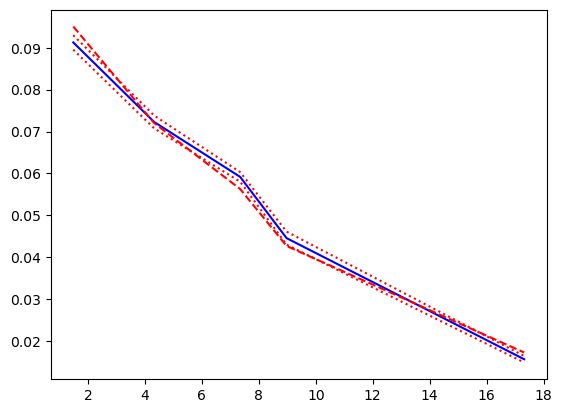

In [69]:
tg = perfil_var(train_df, 'tempo_emprego', ncat=5)
tg.reset_index().style.format({'mau':'{:.1%}', 'tx_ev':'{:.1%}', 'distribuição':'{:.1%}'})

distribuição     score     tx_ev
posse_de_veiculo                                  
N                     0.610282  0.058080  0.058080
S                     0.389718  0.057347  0.057347

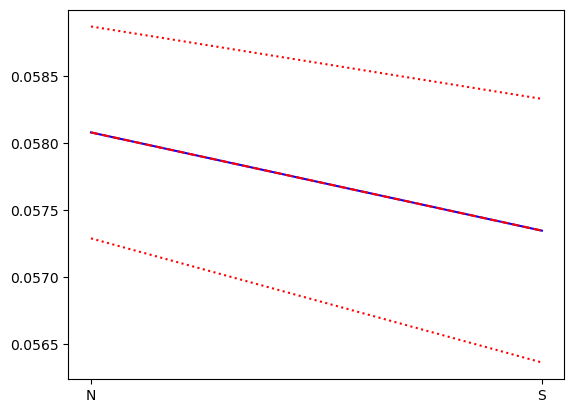

In [71]:
tg = perfil_var(train_df, 'posse_de_veiculo')
tg

distribuição     score     tx_ev
posse_de_imovel                                  
N                    0.328595  0.065624  0.065624
S                    0.671405  0.053963  0.053963

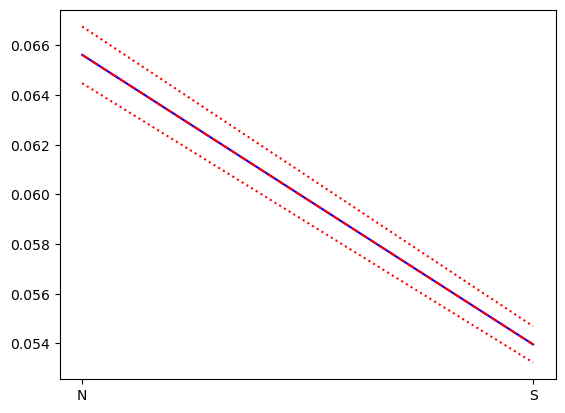

In [72]:
tg = perfil_var(train_df, 'posse_de_imovel')
tg

distribuição    score    tx_ev
educacao                                    
Superior/Pos       0.27364  0.05271  0.05271
sem_superior       0.72636  0.05971  0.05971

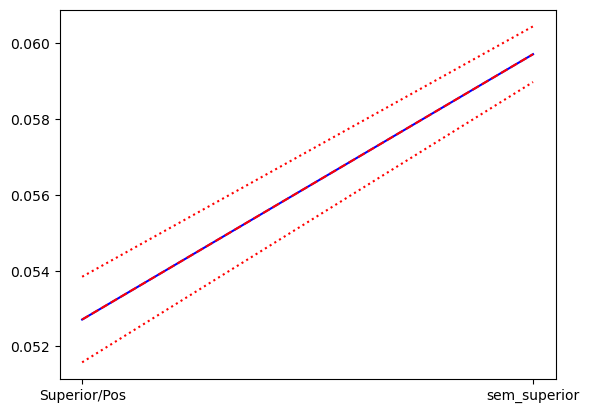

In [74]:
tg = perfil_var(train_df, 'educacao')
tg

distribuição     score     tx_ev
estado_civil                                  
Casado            0.702251  0.056802  0.056802
nao_casado        0.297749  0.060136  0.060136

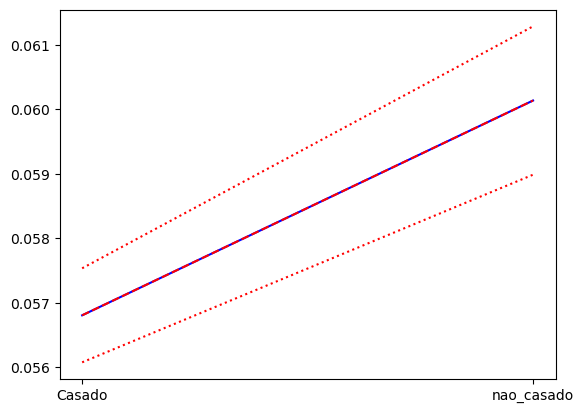

In [65]:
tg = perfil_var(train_df, 'estado_civil')
tg

# Na base de desenvolvimento a metrica está boa, porém na base de teste a metrica esta ruim, isso indica um overfitting provavel, porém ainda mantendo seu bom desempenho para separação de classes. 